In [18]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import PIL
from glob import glob
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.filters import gabor
from skimage import filters


In [19]:
# Directory containing images
DIR = "/kaggle/input/chest-xray-masks-and-labels/data/"

# Fetching all lung X-ray image paths
lung_image_paths = glob(os.path.join(DIR, "Lung Segmentation/CXR_png/*.png"))

# Organizing image paths into a dictionary
related_paths = defaultdict(list)
for img_path in lung_image_paths:
    img_name = os.path.basename(img_path).split(".")[0]
    related_paths["image_path"].append(img_path)

# Converting dictionary to DataFrame for structured access
paths_df = pd.DataFrame.from_dict(related_paths)
print(paths_df.head())


                                          image_path
0  /kaggle/input/chest-xray-masks-and-labels/data...
1  /kaggle/input/chest-xray-masks-and-labels/data...
2  /kaggle/input/chest-xray-masks-and-labels/data...
3  /kaggle/input/chest-xray-masks-and-labels/data...
4  /kaggle/input/chest-xray-masks-and-labels/data...


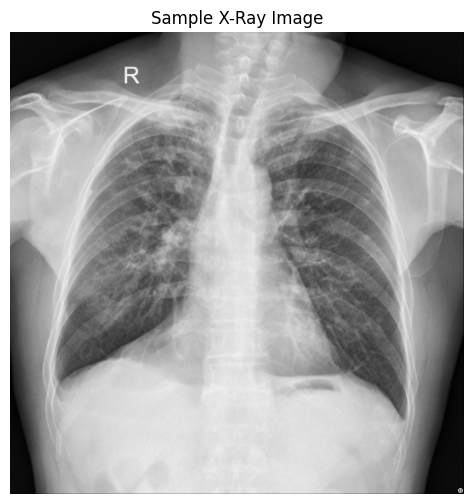

In [20]:
# Visualize a specific sample (e.g., 5th X-ray image)
xray_num = 5
img_path = paths_df["image_path"][xray_num]

# Load and display the image
img = PIL.Image.open(img_path)

# Display the selected image
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap="gray")
plt.title("Sample X-Ray Image")
plt.axis("off")
plt.show()


In [21]:
# Function to preprocess images: Gaussian smoothing and Gabor filtering
def preprocess_images(df, resize_shape=(224, 224), color_mode="gray"):
    x, y = [], []

    for img_path in tqdm(df["image_path"], desc="Processing Images"):
        # Determine label based on filename (example logic for binary classification)
        label = 0 if img_path.endswith("0.png") else 1 if img_path.endswith("1.png") else None
        if label is None:
            continue  # Skip if label is invalid

        # Load and resize image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR if color_mode == "rgb" else cv2.IMREAD_GRAYSCALE)
        resized_img = cv2.resize(img, resize_shape) / 255.0  # Normalize pixel values to [0, 1]

        # Apply Gaussian smoothing
        gaussian_img = cv2.GaussianBlur(resized_img, (5, 5), 0)

        # Apply Gabor filter
        _, gabor_img = gabor(gaussian_img, frequency=0.6)

        # Append processed image and label to lists
        x.append(gabor_img if color_mode == "gray" else np.expand_dims(gabor_img, axis=-1))
        y.append(label)

    return np.array(x), np.array(y)

# Apply preprocessing to the entire dataset
processed_x, processed_y = preprocess_images(paths_df, resize_shape=(224, 224))
print(f"Processed data shape: {processed_x.shape}, Labels shape: {processed_y.shape}")


Processing Images: 100%|██████████| 800/800 [01:29<00:00,  8.91it/s]

Processed data shape: (800, 224, 224), Labels shape: (800,)


In [22]:
# Function to apply filters: histogram equalization, Gaussian smoothing, and Laplacian
def apply_filters(images):
    filtered_images = []
    for image in tqdm(images, desc="Applying Filters"):
        # Apply histogram equalization
        hist_eq = cv2.equalizeHist((image * 255).astype(np.uint8))

        # Apply Gaussian smoothing
        gaussian_filtered = cv2.GaussianBlur(hist_eq, (5, 5), 0)

        # Apply Laplacian filter for edge enhancement
        laplacian_filtered = cv2.Laplacian(gaussian_filtered, cv2.CV_64F)

        filtered_images.append(laplacian_filtered)
    return np.array(filtered_images)

# Apply filters to the processed dataset
filtered_x = apply_filters(processed_x)
print(f"Filtered data shape: {filtered_x.shape}")


Applying Filters: 100%|██████████| 800/800 [00:00<00:00, 962.75it/s] 


Filtered data shape: (800, 224, 224)


In [23]:
# Function to apply edge detection: Sobel, LoG, and Canny
def apply_edge_detection(images):
    edge_detected_images = []
    for image in tqdm(images, desc="Applying Edge Detection"):
        # Apply Sobel operator
        sobel_edges = filters.sobel(image)

        # Apply Laplacian of Gaussian (LoG)
        log_edges = cv2.Laplacian(image, cv2.CV_64F)

        # Apply Canny edge detection
        canny_edges = cv2.Canny((image * 255).astype(np.uint8), 50, 150)

        # Combine all edges
        combined_edges = sobel_edges + log_edges + canny_edges
        edge_detected_images.append(combined_edges)
    return np.array(edge_detected_images)

# Apply edge detection to the filtered dataset
edge_detected_x = apply_edge_detection(filtered_x)
print(f"Edge-detected data shape: {edge_detected_x.shape}")


Applying Edge Detection: 100%|██████████| 800/800 [00:02<00:00, 322.68it/s]


Edge-detected data shape: (800, 224, 224)


In [24]:
# Function to apply data augmentation: flipping, rotation, and brightness adjustment
def augment_images(images):
    augmented_images = []
    for image in tqdm(images, desc="Applying Data Augmentation"):
        # Random flipping
        flipped_img = cv2.flip(image, 1)  # Horizontal flip

        # Random rotation
        rows, cols = image.shape[:2]
        rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle=15, scale=1)
        rotated_img = cv2.warpAffine(image, rotation_matrix, (cols, rows))

        # Brightness adjustment
        bright_img = cv2.convertScaleAbs(image, alpha=1.2, beta=30)

        # Collect augmented images
        augmented_images.extend([image, flipped_img, rotated_img, bright_img])
    return np.array(augmented_images)

# Apply augmentation to the edge-detected dataset
augmented_x = augment_images(edge_detected_x)
print(f"Augmented data shape: {augmented_x.shape}")


Applying Data Augmentation: 100%|██████████| 800/800 [00:00<00:00, 1027.21it/s]


Augmented data shape: (3200, 224, 224)


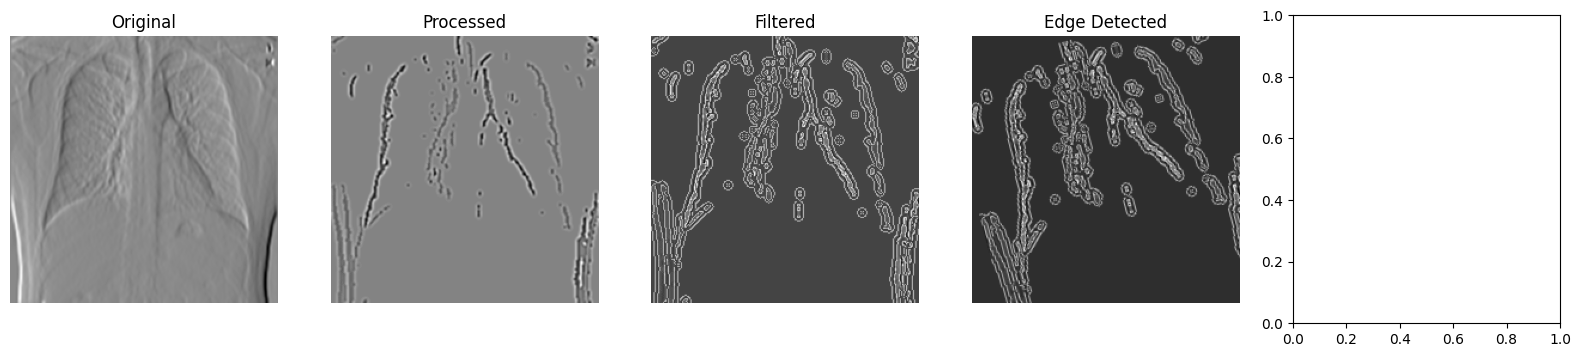

In [25]:
# Visualize a sample from each step
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
titles = ["Original", "Processed", "Filtered", "Edge Detected", "Augmented"]
images = [processed_x[0], filtered_x[0], edge_detected_x[0], augmented_x[2]]

for i, (img, title) in enumerate(zip(images, titles)):
    axs[i].imshow(img, cmap="gray")
    axs[i].set_title(title)
    axs[i].axis("off")
plt.show()


**Classification**

In [26]:
# Import necessary libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [27]:
# Split the data into training (80%), validation (10%), and test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(filtered_x, processed_y, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Print the sizes of each set
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))


Training set size: 640
Validation set size: 80
Test set size: 80


In [28]:
from keras.layers import BatchNormalization

# Define the CNN model
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(BatchNormalization())  # Batch Normalization
model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 4
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten Layer
model.add(Flatten())

# Fully Connected Layer 1
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization
model.add(BatchNormalization())

# Fully Connected Layer 2
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,117,313 (19.52 MB)

 Trainable params: 5,116,097 (19.52 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [29]:
# Define a ModelCheckpoint callback to save the best weights
# Define a ModelCheckpoint callback to save the best weights
checkpoint = ModelCheckpoint("best_weights.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,  # You can increase epochs if needed
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)


Epoch 1/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5715 - loss: 0.7533
Epoch 1: val_accuracy improved from -inf to 0.46250, saving model to best_weights.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.5796 - loss: 0.7429 - val_accuracy: 0.4625 - val_loss: 7.5487
Epoch 2/50
37/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7493 - loss: 0.5145
Epoch 2: val_accuracy improved from 0.46250 to 0.47500, saving model to best_weights.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7478 - loss: 0.5167 - val_accuracy: 0.4750 - val_loss: 2.4392
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7380 - loss: 0.5640
Epoch 3: val_accuracy improved from 0.47500 to 0.50000, saving model to best_weights.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7378 - loss: 0.5638 - val_accuracy: 0.5000 - val_loss: 1.9233
Epoch 4/50
38/40 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7657 - loss: 0.4914
Epoch 4: val_accuracy improved from 0.5000

In [30]:
# Load the best weights
model.load_weights("best_weights.keras")

# Predict on the test data
y_pred = model.predict(X_test)

# Determine the best threshold
threshold = 0
best_accuracy = 0
best_threshold = 0

# Iterate through thresholds to find the best one
for t in np.arange(0.0, 1.1, 0.1):
    y_pred_binary = np.where(y_pred >= t, 1, 0)
    accuracy = accuracy_score(y_test, y_pred_binary)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = t

# Final prediction with the best threshold
y_pred_binary = np.where(y_pred >= best_threshold, 1, 0)
final_accuracy = accuracy_score(y_test, y_pred_binary)

print(f"Best Threshold: {best_threshold}, Test Accuracy: {final_accuracy}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step
Best Threshold: 0.4, Test Accuracy: 0.8125


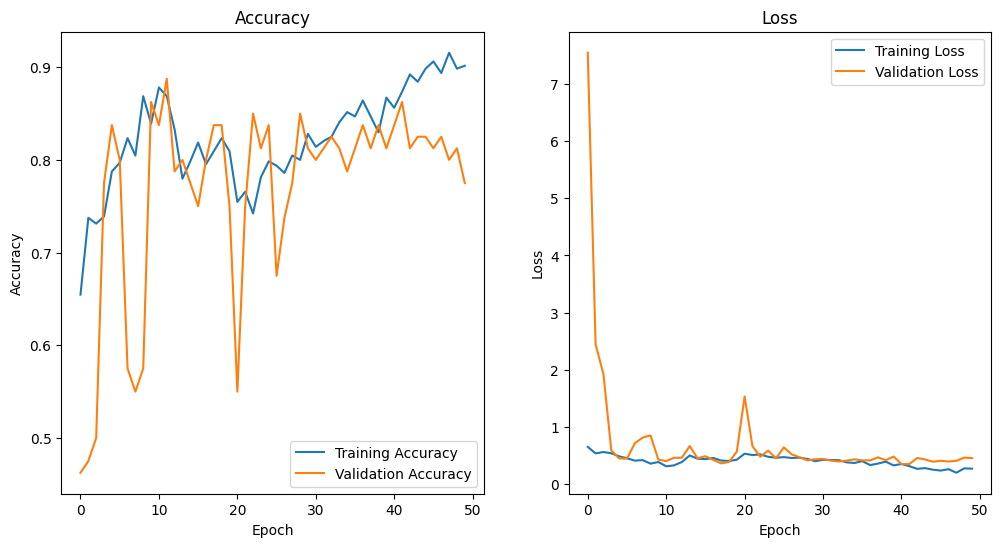

In [31]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
